# Informe - Exploración de modelos de clasificación y calibración

## Análisis Exploratorio y Selección de Modelos con mejorar métricas

Se emprende un análisis exhaustivo de un problema de clasificación, comenzando con un enfoque sistemático para garantizar resultados robustos y confiables. El primer paso en este proceso es realizar un Análisis Exploratorio de Datos (EDA), que permitirá examinar la distribución de las variables en el conjunto de datos de entrenamiento. A través del EDA, se busca identificar patrones subyacentes, outliers, y cualquier irregularidad que pueda influir en el rendimiento de los modelos. Esta etapa es crucial, ya que una comprensión profunda de los datos es fundamental para tomar decisiones informadas en las siguientes fases del análisis.

Una vez extraídas las principales características del conjunto de datos, se procederá a explorar el rendimiento de cuatro modelos de clasificación de gran relevancia: Support Vector Machines (SVM), Random Forest Classifier, Gradient Boosting Trees y Regresión Logística. Cada uno de estos modelos posee sus propias fortalezas y debilidades, y el objetivo es evaluarlos en un entorno controlado para determinar cuál de ellos se adapta mejor al problema en cuestión. A través de la comparación de métricas clave como la precisión, la sensibilidad, la especificidad y el AUC-ROC, se buscará identificar el modelo que ofrezca el mejor equilibrio entre sesgo y varianza.

Además de evaluar el rendimiento base de estos modelos, un aspecto crucial del análisis será la calibración de probabilidades. Muchos modelos de clasificación, especialmente aquellos como SVM y Gradient Boosting Trees, pueden producir predicciones de probabilidad que no están perfectamente calibradas. Esto significa que la probabilidad predicha no siempre refleja adecuadamente la verdadera probabilidad de pertenencia a una clase. Por lo tanto, se examinará si los modelos necesitan un ajuste adicional a través de técnicas de calibración, como la regresión isotónica o el método de Platt, para mejorar la precisión de las probabilidades predichas.

Finalmente, el análisis concluirá con una comparación integral de los resultados obtenidos de los modelos, tanto antes como después de la calibración de probabilidades. El objetivo es identificar el modelo que no solo tenga un alto rendimiento en términos de precisión, sino que también ofrezca predicciones de probabilidad bien calibradas. Este enfoque detallado garantizará que el modelo seleccionado no solo sea el más preciso, sino también el más fiable para la toma de decisiones en la prediccion del riesgo de deslizamiento de tierra.

## Analisis exploratorio de datos (EDA)

### Importación de librerias y definicion de funciones

In [1]:
# import warnings
# warnings.filterwarnings("ignore")
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # Para clasificación SVM
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV,ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score

In [2]:
def cargar_csv(ruta_csv):
    try:
        df = pd.read_csv(ruta_csv)
        return df
    except FileNotFoundError:
        print(f"El archivo en la ruta {ruta_csv} no se encontró.")
    except pd.errors.EmptyDataError:
        print("El archivo CSV está vacío.")
    except pd.errors.ParserError:
        print("Error al analizar el archivo CSV.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

In [3]:
def graficar_histograma(df, y, x, ax):
    sns.histplot(data=df[df[y] == 1], x=x, bins=20, kde=True, color='green', label='1', ax=ax)
    sns.histplot(data=df[df[y] == 0], x=x, bins=20, kde=True, color='red', label='0', ax=ax)
    
    ax.set_xlabel(f'{x}')
    ax.set_ylabel('Frecuencia')
    ax.set_title(f'Histograma de Frecuencia - Precipitación de lluvia acumulada en {x}')
    ax.legend()

In [4]:
def crear_tabla_contingencia(df, columna1, columna2):

    tabla_contingencia = pd.crosstab(df[columna1], df[columna2]).reset_index(drop=False)
    tabla_contingencia.index.name = None
    tabla_contingencia.columns.name = None
    tabla_contingencia=tabla_contingencia.sort_values(by=0,ascending=False)
    return tabla_contingencia

### Data de entrenamiento

Importamos los conjuntos de datos de entrenamiento con el que contamos, los cuales pasaron por un pre-procesamiento para tenerlos listos para la analitica. Estos son provenientes de los archivos Eventos_SI_MM.csv y Eventos_NO_MM.csv proporcionados por la oficina de SATIC de la alcaldia de Cali. Estos contienen datos sobre de precipitaciones en diferentes periodos de tiempo, algunas características del suelo y la categorización binaria si hubo un derrumbe o no

A continuación podemos ver la biblioteca de datos de las variables iniciales a tomar en cuenta con su descripción:

| Variable   | Descripción |
|------------|--------|
| ELEVACION | Elevación del punto de movimiento en masa en metros sobre el nivel del mar (msnm) |
| PENDIENT |  Pendiente del punto de movimiento en masa en porcentaje (%) |
| zonificacion | Nombre de la clasificación de amenaza o riesgo del punto de movimiento en masa |
| Nomenclatura_del_Suelo | Nombre de la cobertura de suelo Metodologia Land Corine Escala 1:25000 |
| tipo_geologia | Nomenclatura de la unidad geológica asociada al punto de movimiento en masa |
| 24h | Lluvia acumulada en 24 horas en milímetros |
| 7d | Lluvia acumulada en 7 dias en milímetros |
| 10d | Lluvia acumulada en 10 dias en milímetros |
| 15d | Lluvia acumulada en 15 dias en milímetros |
| 30d | Lluvia acumulada en 30 dias en milímetros |
| 60d | Lluvia acumulada en 60 dias en milímetros |
| 90d | Lluvia acumulada en 90 dias en milímetros |
| deslizamientos | numero que indica si hubo deslizamiento de tierra en el punto de movimiento en masa |

## Exploración de tendencias

In [5]:
df=cargar_csv(os.path.join('..','Data','output','train_data_1.csv'))

In [6]:
df.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d,deslizamientos
0,1085.033813,36.388821,Riesgo alto,Otras superficies artificiales sin construcción,Formacion Volcanica,20.0,33.0,38.0,254.0,477.0,773.0,872.0,1
1,1027.715698,25.132856,Amenaza baja,Bosque mixto denso bajo de tierra firme,Formacion Jamundi,13.0,17.0,17.0,51.0,65.0,118.0,252.0,0
2,1173.279907,14.109338,Amenaza baja,Pasto cultivado enmalezado,Formacion Jamundi,0.0,7.2,21.1,23.1,128.3,292.7,599.4,0
3,973.211731,12.891751,Riesgo bajo,Zonas urbanas continuas,Cono aluvial rio Melendez,0.0,17.9,22.3,41.1,70.2,249.0,363.0,0
4,1062.026245,9.081903,Amenaza baja,Bosque mixto fragmentado con pastos y cultivos,Cono aluvial 1 rio Pance,0.0,48.1,88.6,163.4,304.6,533.0,722.6,0


En esta sección el objetivo es identificar posibles problemas, como datos faltantes, valores atípicos o distribuciones no esperadas, ver si hay alta multicolinealidad en datos, mirar cómo se comportan las variables categóricas, comparar modelos de clasificación paramétricos y no paramétricos y tomar medidas para abordarlos de manera efectiva.

### Variables numericas

Primeramente, es comun en problema de clasificacion revisar si se trata de un problemas de clases desbalanceadas o no.
El desbalance de datos en el aprendizaje automático ocurre cuando hay muchas más muestras de una cosa que de otra. Por ejemplo en este caso, si queremos  detectar deslizamientos de tierra y la mayoría de los registros reportan un no deslizamiento, puede ser difícil para un modelo identificar los deslizamientos porque tiene menos ejemplos para aprender de ellos. Es importante revisar esto al explorar los datos para asegurarse de que el modelo pueda hacer predicciones precisas y útiles. Sin abordar este desbalance, el modelo podría no funcionar correctamente.

Para esto haremos una revision simple de cuantos registros hay de cada clase

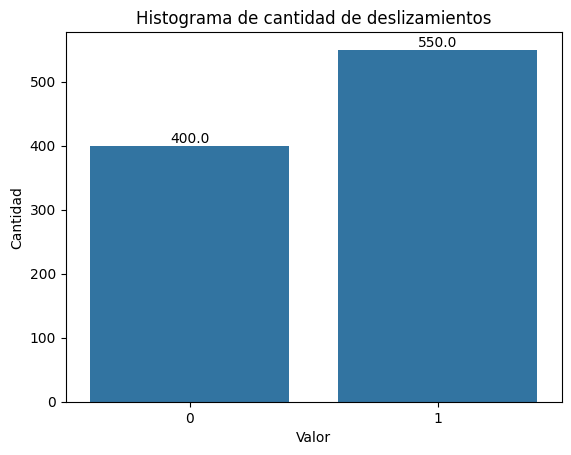

In [7]:
# Grafica el histograma usando Seaborn
ax=sns.countplot(data=df, x='deslizamientos')

# Añade etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Cantidad')
plt.title('Histograma de cantidad de deslizamientos')
# Agrega los valores en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

Como podemos ver, no se presenta un problema grande de desbalance, ya que hay una relación de aproximadamente 40/60 de cada tipo de clase, por lo general se establece que hay desbalance de clases cuando hay una relación 10/90. Pero vemos que este no es el caso

Ahora vemos como se comportan las variables de precipitación de lluvia respecto la variable objetivo

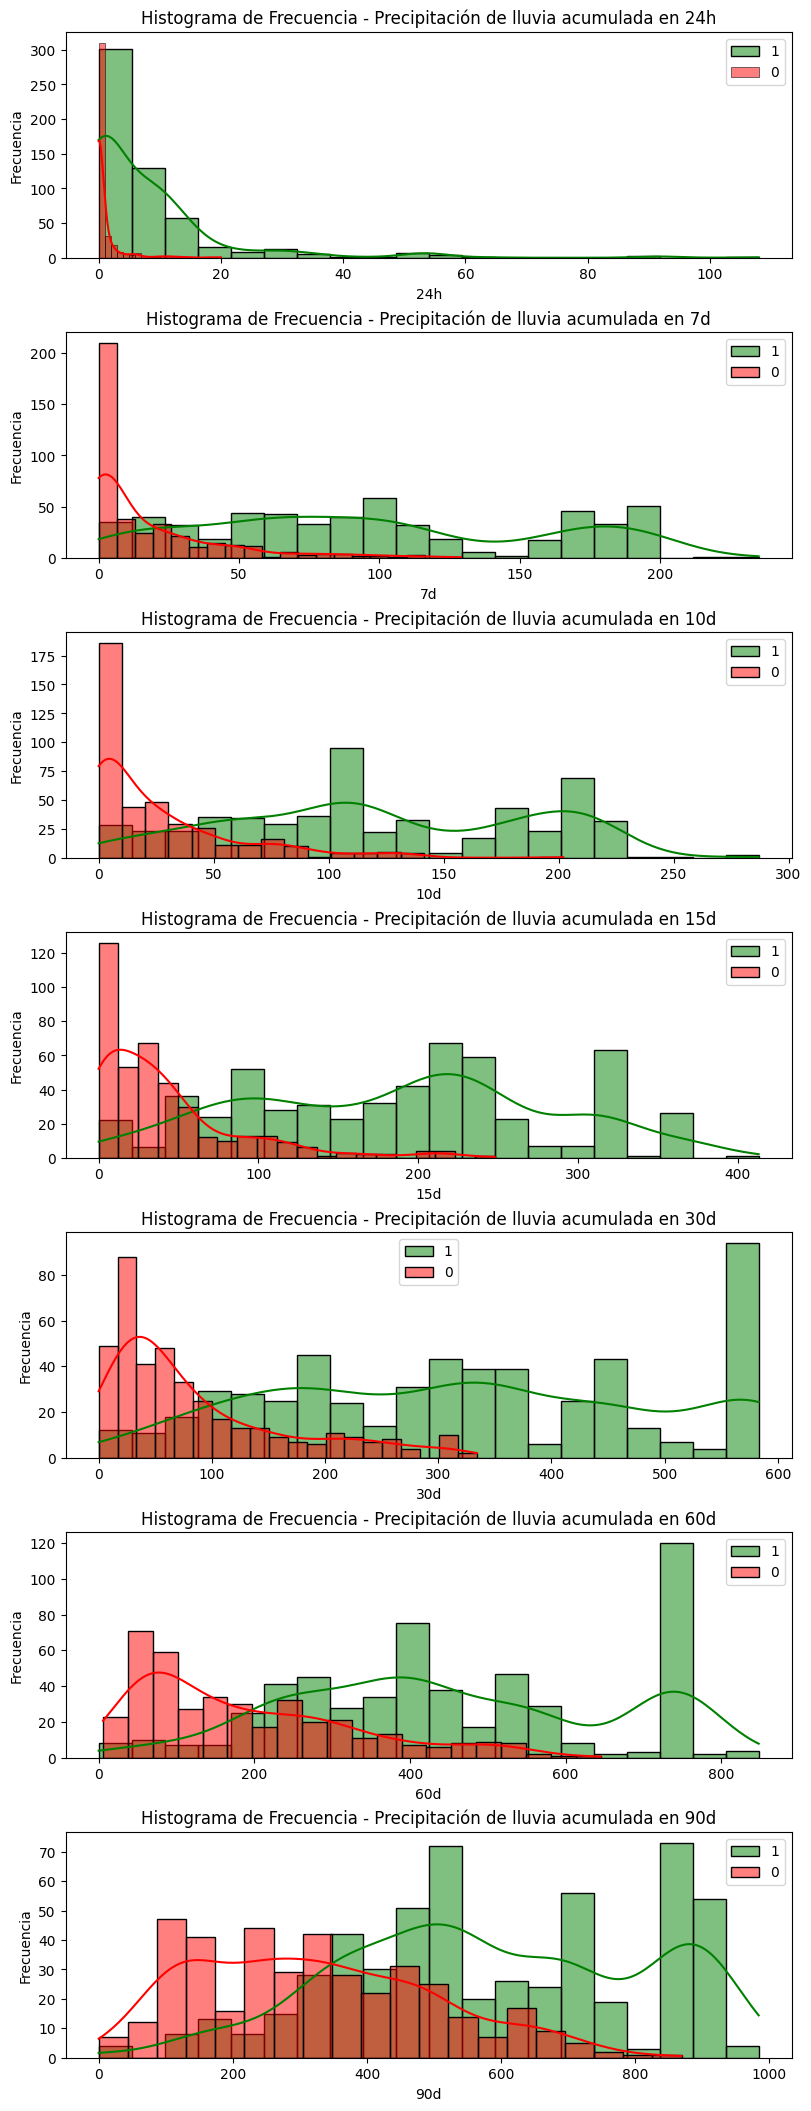

In [8]:
columnas_a_graficar = ['24h', '7d', '10d','15d','30d','60d','90d'] 
n = len(columnas_a_graficar)
fig, axes = plt.subplots(n, 1, figsize=(8, 3 * n), constrained_layout=True)
if n == 1:
    axes = [axes]
for columna, ax in zip(columnas_a_graficar, axes):
    graficar_histograma(df, y='deslizamientos', x=columna, ax=ax)
plt.show()

En este caso vemos que tenemos que para puntos donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en los últimos 15 días en comparación con los que no han presentado deslizamientos. Esto nos da un indicio de que las variables de precipitación son importantes para estimar si existe deslizamientos o no

Tambien podremos pensar que al tratarse de variables que capturan data de manera acumulada, puede haber valor que da una variable que tambien lo de otra, podemos revisar las correlaciones entre las precipitaciones

### Variables categoricas

Ahora veamos las relaciones de las variables categoricas con el objetivo

In [9]:
resultados = {}
columnas_comparar=['zonificacion','Nomenclatura_del_Suelo','tipo_geologia']
for c in columnas_comparar:
    tabla = crear_tabla_contingencia(df, c, 'deslizamientos')
    resultados[c] = tabla

In [10]:
resultados['zonificacion']

,zonificacion,0,1
5,Riesgo bajo,206,169
1,Amenaza baja,194,15
0,Amenaza alta,0,26
2,Amenaza media,0,27
3,Amenaza muy alta,0,3
4,Riesgo alto,0,206
6,Riesgo medio,0,104


In [11]:
resultados['Nomenclatura_del_Suelo']

,Nomenclatura_del_Suelo,0,1
25,Zonas urbanas continuas,98,401
20,Pasto cultivado arbolado,50,9
19,Pasto cultivado,38,10
26,Zonas urbanas discontinuas,36,25
8,Bosque mixto denso bajo de tierra firme,25,9
21,Pasto cultivado enmalezado,20,3
9,Bosque mixto fragmentado con pastos y cultivos,18,0
15,Otras superficies artificiales con construcción,15,1
24,Vegetación secundaria o transición,14,11
7,Bosque mixto denso alto de tierra firme,13,14


In [12]:
resultados['tipo_geologia']

,tipo_geologia,0,1
8,Formacion Jamundi,96,3
10,Lateritas Formacion Volcanica,86,113
9,Formacion Volcanica,84,345
1,Cono aluvial 2 rio Pance,37,1
0,Cono aluvial 1 rio Pance,28,0
2,Cono aluvial rio Melendez,20,5
7,Formacion Guachinte,20,79
6,Formacion Ferreira,15,0
4,Depositos aluviales,7,1
3,Conos aluviales,3,1


Las variables categóricas con muy pocas frecuencias pueden presentar varios desafíos y consideraciones, por ejemplo:

- Sobre-ajuste: Las categorías que aparecen solo unas pocas veces pueden llevar a modelos que se ajustan demasiado a esos casos específicos, capturando el ruido en lugar de patrones generales. Esto puede disminuir la capacidad de generalización del modelo a datos no vistos. 

- Estabilidad en el entrenamiento: Dado que el modelo tiene pocos ejemplos de estas categorías, puede ser difícil para el modelo aprender patrones representativos. Las categorías con baja frecuencia pueden no tener suficientes datos para permitir que el modelo aprenda características significativas, lo que puede llevar a una mala representación de esas categorías en el modelo.

Todo esto puede afectar en las métricas de evaluación, como la precisión, el recall, y la F1-score, ya que el rendimiento en estas categorías raras puede no estar bien representado

### Correlaciones entre variables independientes

Queremos que haya la menor correlación lineal y no lineal entre las variables independientes, ya que queremos que cada variable aporte su valor único al modelo, y evitar redundancias

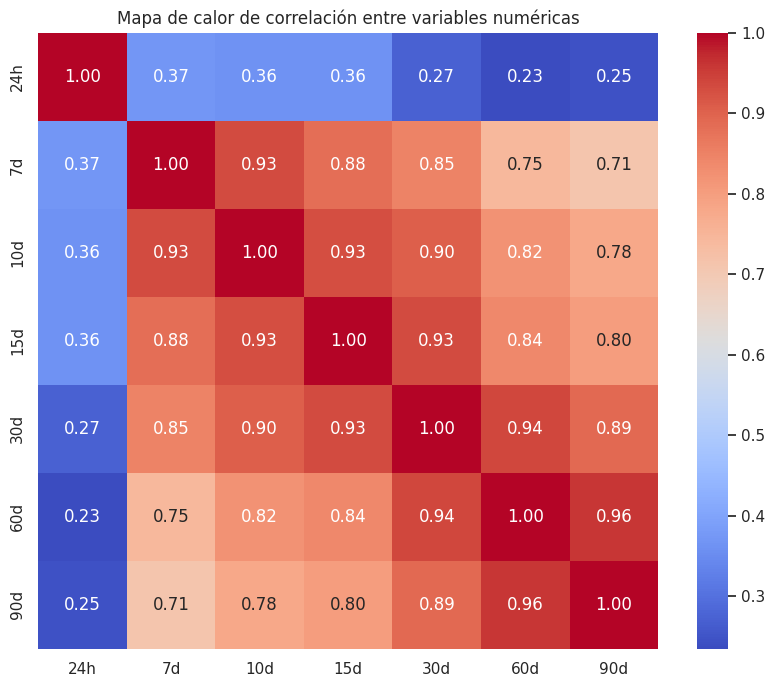

In [13]:
# Correlaciones entre variables independientes
correlation_matrix = df[columnas_a_graficar].corr(method='pearson')

# Configurar el estilo del mapa de calor

sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlación lineal entre las variables principalmente de precipitación, dándonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así sucesivamente) aumenta su dependencia.

Esto genera multicolinealidad, lo que puede hacer que los coeficientes en modelos lineales (como la regresión logística, que se modelará en este analisis) se vuelvan inestables y difíciles de interpretar, esto ocurre porque el modelo no puede distinguir fácilmente el efecto individual de cada variable correlacionada. 

Así mismo, las variables altamente correlacionadas aportan información redundante. Esto puede hacer que el modelo sea más complejo de lo necesario, sin mejorar el rendimiento predictivo, lo cual puede llevar a un modelo sobreajustado que no generaliza bien a datos nuevos. En algunos casos, los algoritmos de clasificación uqe se usaran en este analisis, como los árboles de decisión o los modelos basados en conjuntos (e.g., Random Forest, XGBoost), no se ven tan afectados por la multicolinealidad, pero la presencia de variables altamente correlacionadas puede todavía llevar a un modelo más complejo de lo necesario.

## Modelado

Dentro de los modelos de aprendizaje automático para problemas de clasificación, se ejecutaran pruebas de rendimiento para modelos de ensamble como lo son Random Forest y XGBoost, para modelos basados en el hiperplano como el SVM (support vector machines), y modelos de regresion para clasificacion como lo es la regresion logistica


- Máquinas de Vectores de Soporte (SVM)


- Bosques Aleatorios (Random Forest)


- XGBoost (Extreme Gradient Boosting Trees)


- Rgresión Logistica 

### Metodologia propuesta

El objetivo es implementar una tubería de datos (pipeline) tal que cuando lleguen los datos nuevos a estimar, estos pasen por las mismas transformaciones por las que pasaron los datos de entrenamiento. Más precisamente hablando, el pipeline en scikit-learn es una herramienta que te permite concatenar varios pasos de procesamiento de datos y modelado en un solo objeto. Esto facilita la construcción, entrenamiento y evaluación de modelos de aprendizaje automático, ya que puedes encapsular todo el flujo de trabajo en una única estructura.

De la misma manera, se busca optimizar las estimaciones y la calidad de los modelos, por lo que se usa la metodología de Grid search o búsqueda de malla para optimizar parámetros dentro de los modelos. Es una herramienta poderosa para optimizar los parámetros de un modelo de aprendizaje automático. Permite definir una cuadrícula de valores para diferentes parámetros del modelo y busca exhaustivamente la mejor combinación de estos parameros, a lo que se le llama hiperparametrizacion.

En términos más simples, el GridSearchCV realiza una búsqueda exhaustiva sobre una cuadrícula de valores especificados para los hiperparámetros de un estimador. Esto permite encontrar la combinación óptima de hiperparámetros que maximiza la precisión o cualquier otra métrica de evaluación definida.

La idea detrás del GridSearchCV es que, en lugar de ajustar manualmente los hiperparámetros del modelo y evaluar su rendimiento, el proceso se automatiza y se realiza de manera sistemática. Esto ahorra tiempo y esfuerzo, ya que el GridSearchCV evalúa todas las combinaciones posibles de los hiperparámetros dentro de la cuadrícula especificada y selecciona la mejor combinación según la métrica de evaluación especificada.

Tercero, se propone usar validación cruzada aleatoria y dividida. Esto con el proposito de no usar la clasica division unitaria de entrenamiento-pruba, ya que en este tipo de división el entrenamiento o aprendizake del modelo puede quedar sesgado debido a que al dividir aleatoriamente no sabemos con que proporción de los datos el modelo aprende, por ejemplo, al dividir una sola vez el conjunto de datos nos puede quedar que en el conjunto de test solo haya valores con el label de 0 (no deslizamiento en este caso) y en el entrenamiento solo existan registros del label 1 (deslizamientos), esto puede ocasionar que el modelo no aprenda de la manera más optima.

Con la validación cruzada aleatoria y dividida (shuffle-split). En la validación cruzada de división aleatoria, cada división (split) está compuesta de tanto train_size puntos (disyuntos) para el conjunto de entrenamiento y tantos test_size puntos (disjuntos) para el conjunto de prueba, se fijen inicialmente. Esta división se repite n veces, de forma aleatoria. Por ejemplo en la siguiente imagen, para la ejecución de cuatro iteraciones de división de un conjunto de datos que consta de 10 puntos, con un conjunto de entrenamiento de 5 puntos y conjuntos de prueba de 2 puntos cada uno

Por ultimo, se busca indagar si el clasificador escogido necesita calibracion de probabilidades o no, la calibración de probabilidades se utiliza para ajustar las probabilidades predichas por un modelo de clasificación para que reflejen mejor las probabilidades reales observadas. En un problema de clasificación binaria, como lo es el actual, el modelo no solo predice qué clase es la más probable, sino también una probabilidad asociada a esa predicción

### Desarrollo

#### Parametrizacion

In [14]:
independent_var_erase=[]
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [15]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia']
Variables numericas:  ['ELEVACION', 'PENDIENT', '24h', '7d', '10d', '15d', '30d', '60d', '90d']
Variables independientes:  ['zonificacion', 'Nomenclatura_del_Suelo', 'tipo_geologia', 'ELEVACION', 'PENDIENT', '24h', '7d', '10d', '15d', '30d', '60d', '90d']


In [16]:
# Crea un diccionario para los codificadores
label_encoders = {}

for feature in VAR_categorical_cols:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

/tmp/ipykernel_18089/1787025087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = le.fit_transform(X[feature])
/tmp/ipykernel_18089/1787025087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = le.fit_transform(X[feature])
/tmp/ipykernel_18089/1787025087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [18]:
shuffle_split = ShuffleSplit(test_size=.3, train_size=.7, n_splits=10)

In [19]:
param_grid_rf = {
    'classifier__n_estimators': [100,250,500], 
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
    }

In [20]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

In [21]:
pipeline_rf= Pipeline([
    #('preprocessor',preprocessor_rf),
    ('classifier', RandomForestClassifier())
])
pipeline_rf

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [22]:
X_train.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d
213,1048.251831,83.090614,4,25,9,14.0,56.0,143.0,233.0,428.0,592.0,750.0
530,1270.673706,4.419975,5,24,10,0.0,5.0,5.0,10.1,13.1,95.1,197.1
225,990.387940,26.095905,5,25,9,0.0,18.0,42.0,211.0,430.0,753.0,859.0
104,975.455810,9.951165,5,25,2,0.0,2.0,2.0,2.6,24.8,66.7,196.8
837,1025.526733,13.400908,1,19,8,0.0,6.0,6.0,36.0,36.0,82.0,117.0


In [23]:
X_valid.head()

,ELEVACION,PENDIENT,zonificacion,Nomenclatura_del_Suelo,tipo_geologia,24h,7d,10d,15d,30d,60d,90d
185,1714.819214,14.391762,5,25,9,11.0,88.0,89.0,102.0,133.0,191.0,237.0
781,1094.002075,62.839706,4,25,7,24.4,114.8,139.0,165.2,262.6,371.2,449.0
402,1181.329590,12.119770,1,1,8,14.0,13.8,13.8,42.1,43.1,50.5,96.9
771,1057.827637,22.818035,5,25,10,20.1,111.3,112.0,216.2,266.7,351.0,454.0
167,1187.821167,34.134590,1,21,8,0.0,0.4,12.6,14.8,266.8,498.8,742.2


In [24]:
grid_search = GridSearchCV(pipeline_rf, param_grid_rf, cv=shuffle_split,scoring='recall')
grid_search.fit(X_train, y_train)
msg_training=f"Rendimiento en training -> RandomForestClassifier \n Puntaje recall en entrenamiento: {grid_search.best_score_}, \n modelo ganador: {grid_search.best_estimator_} \n mejor combinacion de parametros: {grid_search.best_params_}"
print(msg_training)
model_rf=grid_search.best_estimator_

Rendimiento en training -> RandomForestClassifier 
 Puntaje recall en entrenamiento: 0.9567340310116433, 
 modelo ganador: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=500))]) 
 mejor combinacion de parametros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}


In [25]:
y_pred = model_rf.predict(X_valid)
recall = recall_score(y_valid, y_pred)
print(f"Recall en test para RandomForestClassifier: {recall}")

Recall en test para RandomForestClassifier: 0.9607843137254902
